# Example notebook (simulated data)

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
from novaice.tl import ChemPertVAEModel, ChemPertMLPModel
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import TensorBoardLogger

/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [3]:
path = "/Users/michaelbaggiolorenz/Desktop/personal/BioHackathon_2025/nucleate-hackathon-2025/data/MCE_Bioactive_Compounds_HEK293T_10μM.h5ad"
adata = ad.read_h5ad(path)

In [4]:
N = adata.n_obs  # or whatever your dataset length is
indices = np.arange(N)

training_compounds, testing_compounds = train_test_split(
    adata.obs["treatment"].unique(), test_size=0.2, random_state=42, shuffle=True
)

adata_train = adata[adata.obs["treatment"].isin(training_compounds)].copy()
adata_test = adata[adata.obs["treatment"].isin(testing_compounds)].copy()

## VAE

In [5]:
# Setup and train model with validation split
ChemPertVAEModel.setup_anndata(
    adata_train, 
    drug_embedding_key="foundation_embedding"
)
model = ChemPertVAEModel(adata_train)

# Create TensorBoard logger
tb_logger = TensorBoardLogger("logs", name="chempert_vae_transfer")

model.train(
    max_epochs=50,
    logger=tb_logger,
    log_every_n_steps=5,
    check_val_every_n_epoch=1,  # Validate every epoch
    train_size=0.8,  # Use 80% of data for training
    validation_size=0.2,  # Use 20% of data for validation
)
# Predict gene expression
predictions = model.predict_gene_expression()
# Get latent representation
latent = model.get_latent_representation()

INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 50/50: 100%|██████████| 50/50 [02:18<00:00,  2.73s/it, v_num=1, train_loss=4.93e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [02:18<00:00,  2.76s/it, v_num=1, train_loss=4.93e+3]


INFO     Generating sequential column names                                                                        
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(array([ 15.,   8.,   7.,  11.,  18.,  14.,  11.,  16.,  12.,  21.,  17.,
         43.,  27.,  27.,  21.,  37.,  31.,  22.,  42.,  22.,  34.,  40.,
         32.,  35.,  36.,  42.,  47.,  55.,  44.,  49.,  81.,  81., 111.,
        111., 138., 169., 216., 275., 383., 518., 711., 896., 991., 800.,
        280.,  22.,   1.,   0.,   0.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
        0.91836735, 0.93877551, 0.95918367, 0.979591

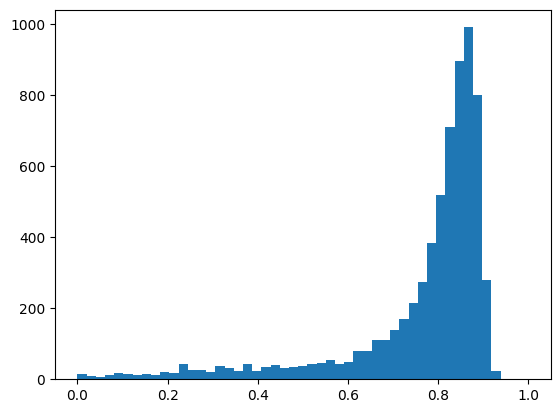

In [6]:
# Setup evaluation data
ChemPertVAEModel.setup_anndata(adata_test, drug_embedding_key="foundation_embedding")

eval_predictions = model.predict_gene_expression(adata_test)
eval_error = model.get_prediction_error(adata_test, method="r2")

plt.hist(eval_error, bins=np.linspace(0,1,50))

## Transfer Learning: Fine-tune on New Dataset

In [7]:
path = "/Users/michaelbaggiolorenz/Desktop/personal/BioHackathon_2025/nucleate-hackathon-2025/data/MCE_Bioactive_Compounds_MDA_MB_231_10μM.h5ad"
adata_new = ad.read_h5ad(path)

In [8]:
N = adata_new.n_obs  # or whatever your dataset length is
indices = np.arange(N)

training_compounds, testing_compounds = train_test_split(
    adata_new.obs["treatment"].unique(), test_size=0.2, random_state=42, shuffle=True
)

adata_new_train = adata_new[adata_new.obs["treatment"].isin(training_compounds)].copy()
adata_new_test = adata_new[adata_new.obs["treatment"].isin(testing_compounds)].copy()

In [9]:
# Fine-tune with different sample sizes
n_finetune_sizes = [10, 100, 1000, 10000]

# Use maximum available samples or requested size
max_samples = min(max(n_finetune_sizes), adata_new_train.n_obs - 100)  # Reserve 100 for eval
adata_eval = adata_new_train[max_samples:].copy()

print(f"Total samples available: {adata_new_train.n_obs}")
print(f"Evaluation samples: {adata_eval.n_obs}")
print(f"Will train models with: {n_finetune_sizes} samples")

Total samples available: 34052
Evaluation samples: 24052
Will train models with: [10, 100, 1000, 10000] samples


In [10]:
# Train models with different fine-tuning sample sizes
finetuned_models = {}

for n_finetune in n_finetune_sizes:
    if n_finetune > adata_new_train.n_obs - adata_eval.n_obs:
        print(f"Skipping n={n_finetune} (not enough samples)")
        continue
    
    print(f"\n{'='*50}")
    print(f"Fine-tuning with {n_finetune} samples")
    print(f"{'='*50}")
    
    # Create fine-tuning subset
    adata_finetune = adata_new_train[:n_finetune].copy()
    
    # Setup new dataset
    ChemPertVAEModel.setup_anndata(adata_finetune, drug_embedding_key="foundation_embedding")
    
    # Create new model instance
    model_finetuned = ChemPertVAEModel(adata_finetune)
    
    # Load the trained weights from the original model
    model_finetuned.module.load_state_dict(model.module.state_dict(), strict=False)
    
    # Freeze all layers except the last decoder layer
    for name, param in model_finetuned.module.named_parameters():
        if 'decoder' not in name or 'px_r' in name:
            param.requires_grad = False
        else:
            param.requires_grad = True
    
    # Fine-tune
    tb_logger = TensorBoardLogger("logs", name=f"chempert_vae_transfer_n{n_finetune}")
    model_finetuned.train(
        max_epochs=20,
        logger=tb_logger,
        train_size=1.0 if n_finetune <= 10 else 0.9,
    )
    
    # Store the model
    finetuned_models[n_finetune] = model_finetuned
    print(f"✓ Fine-tuning with {n_finetune} samples complete!")

print(f"\n{'='*50}")
print(f"All fine-tuning complete!")
print(f"{'='*50}")


Fine-tuning with 10 samples
INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 20/20: 100%|██████████| 20/20 [00:00<00:00, 145.80it/s, v_num=2, train_loss=6.67e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:00<00:00, 139.87it/s, v_num=2, train_loss=6.67e+3]
✓ Fine-tuning with 10 samples complete!

Fine-tuning with 100 samples
INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 20/20: 100%|██████████| 20/20 [00:00<00:00, 118.52it/s, v_num=2, train_loss=6.27e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:00<00:00, 119.39it/s, v_num=2, train_loss=6.27e+3]
✓ Fine-tuning with 100 samples complete!

Fine-tuning with 1000 samples
INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 20/20: 100%|██████████| 20/20 [00:01<00:00,  9.57it/s, v_num=2, train_loss=5.45e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, v_num=2, train_loss=5.45e+3]
✓ Fine-tuning with 1000 samples complete!

Fine-tuning with 10000 samples
INFO     Generating sequential column names                                                                        


/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/novaice/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in th

Epoch 20/20: 100%|██████████| 20/20 [00:17<00:00,  1.22it/s, v_num=2, train_loss=5.3e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, v_num=2, train_loss=5.3e+3]
✓ Fine-tuning with 10000 samples complete!

All fine-tuning complete!


In [11]:
# Evaluate all models on the same evaluation set

# Setup evaluation data
ChemPertVAEModel.setup_anndata(adata_eval, drug_embedding_key="foundation_embedding")

# Store results
results = {}

# Evaluate original model (no fine-tuning)
eval_predictions_original = model.predict_gene_expression(adata_eval)
eval_error_original = model.get_prediction_error(adata_eval, method="r2")
results['Original'] = eval_error_original

print(f"Original model R2 score: {eval_error_original.mean():.4f}")

# Evaluate each fine-tuned model
for n_finetune, model_finetuned in finetuned_models.items():
    eval_predictions = model_finetuned.predict_gene_expression(adata_eval)
    eval_error = model_finetuned.get_prediction_error(adata_eval, method="r2")
    results[f'Fine-tuned (n={n_finetune})'] = eval_error
    
    improvement = eval_error.mean() - eval_error_original.mean()
    print(f"Fine-tuned (n={n_finetune}) R2 score: {eval_error.mean():.4f} (Δ={improvement:+.4f})")

INFO     Generating sequential column names                                                                        
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Original model R2 score: -1.6501
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Fine-tuned (n=10) R2 score: -1.7545 (Δ=-0.1043)
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Fine-tuned (n=100) R2 score: -0.8756 (Δ=+0.7745)
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Fine-tuned (n=1000) R2 score: -1.0001 (Δ=+0.6500)
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Fine-tuned (n=10000) R2 score: -0.8297 (Δ=+0.8204)


/var/folders/qv/ns12p5656nn2gys8msyxrjcm0000gn/T/ipykernel_94290/2636493171.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(results.values(),


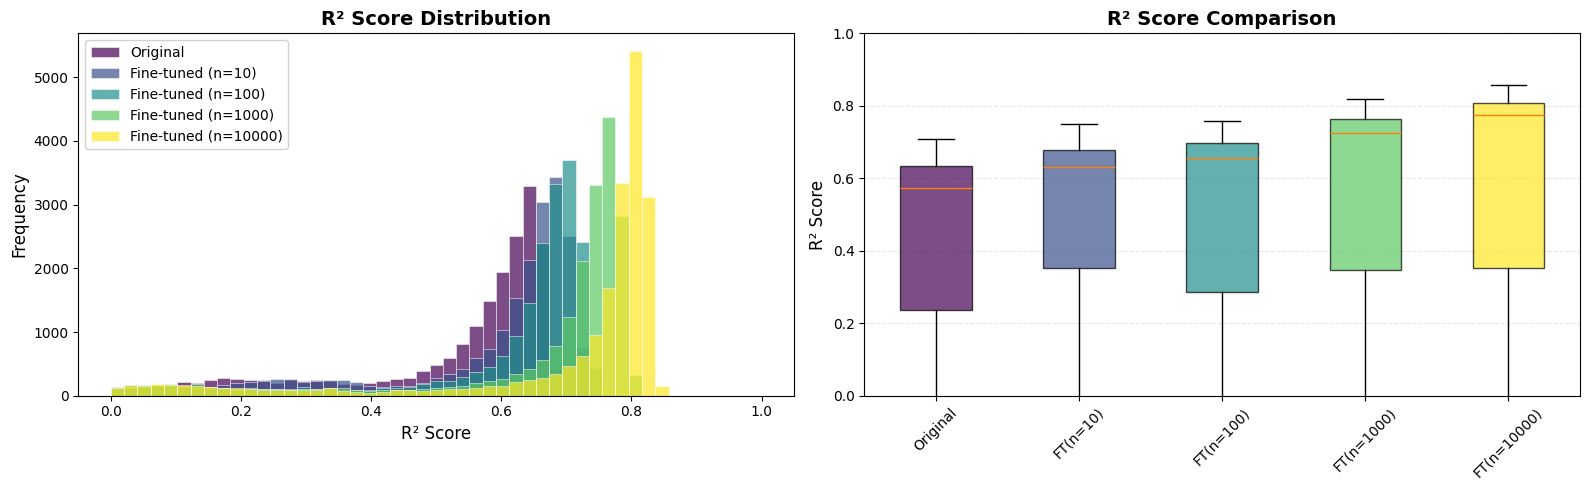


Summary Statistics:
Original                      : mean=-1.6501, std=7.6802
Fine-tuned (n=10)             : mean=-1.7545, std=8.3228
Fine-tuned (n=100)            : mean=-0.8756, std=5.1371
Fine-tuned (n=1000)           : mean=-1.0001, std=5.8200
Fine-tuned (n=10000)          : mean=-0.8297, std=5.3399


In [25]:
# Compare all models
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histogram comparison with viridis colors
bins = np.linspace(0, 1, 50)
n_models = len(results)
colors = [viridis(i / (n_models - 1)) for i in range(n_models)]

for i, (label, scores) in enumerate(results.items()):
    ax1.hist(scores, bins=bins, alpha=0.7, label=label, color=colors[i], edgecolor='white', linewidth=0.5)

ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('R² Score Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, framealpha=0.9)
# ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.set_facecolor('#F8F8F8')

# Box plot comparison
positions = range(len(results))
bp = ax2.boxplot(results.values(), 
            labels=[k.replace('Fine-tuned ', 'FT') for k in results.keys()],
            showmeans=True,
            patch_artist=True)

# Color the box plots with viridis
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0,1)
# ax2.set_facecolor('#F8F8F8')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print("="*60)
for label, scores in results.items():
    print(f"{label:30s}: mean={scores.mean():.4f}, std={scores.std():.4f}")